In [2]:
import m2aia as m2
import numpy as np
import umap
import os
from sklearn import cluster
import matplotlib.pyplot as plt 
import seaborn as sea
import torch

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import Adam
import matplotlib.pyplot as plt

In [3]:
# figures
max_dim = 0
img_size = 124
target_path = "/home/jtfc/HS/M2aiaPy"
cols = 15
# clustering
n_neighbors = 10

#===================================
# 1. Load image handles
#===================================
# data handling
from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639()
image_handles = []
for f in file_names:
    I = m2.ImzMLReader(f)
    # I.SetPooling(m2.m2PoolingMaximum)
    # I.SetNormalization(m2.m2NormalizationTIC)
    # I.SetBaselineCorrection(m2.m2BaselineCorrectionMedian, 50)
    I.Execute()
    xs = I.GetXAxis()
    image_handles.append(I)

In [4]:
#===================================
# 1.2 Using the SpectrumData for strategy III models
#===================================
# we can add a neighborhood size
dataset = m2.SpectrumDataset(image_handles, neighborhood_size=1, buffer_type="memory")

# this returns now all 9 spectra of the 3x3 neighborhood
print("3x3 => [N=9,D]",dataset[0].shape)
# N := spectra in neighborhood
# D := spectrum depth

# or 25 spectra of the 5x5 if neighborhood_size is set to 2
dataset = m2.SpectrumDataset(image_handles, neighborhood_size=2, buffer_type="memory")
print("5x5 => [N=25,D]",dataset[0].shape)

# input of size (N,D) e.g. 1d convolutions expect [C,L]
trafo = transforms.Compose([
    transforms.Lambda(lambda x: np.transpose(x)), #=> (D,9)
    transforms.Lambda(lambda x: np.reshape(x, (1, x.shape[0], int(np.sqrt(x.shape[1])), int(np.sqrt(x.shape[1]))))), #=> (1,D,3,3)
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))])

dataset = m2.SpectrumDataset(image_handles, neighborhood_size=1, buffer_type="memory", transforms=trafo)
print("3x3 => [B,C=1,D,H=3,W=3]",dataset[0].shape)

3x3 => [N=9,D] (9, 29693)
5x5 => [N=25,D] (25, 29693)
3x3 => [B,C=1,D,H=3,W=3] torch.Size([1, 29693, 3, 3])


In [5]:
from Example_VI_Helpers import VAE, VAE_Loss
epochs = 7
batch_size = 128
latent_size = 5

m = VAE(xs.shape[-1],interim_dim=512, latent_size=latent_size)
m = m.cuda()

In [6]:

# if os.path.exists("CLR.model"):
#     #===================================
#     # 3A Load trained model parameters
#     #===================================
#     state_dict = torch.load("CLR.model")
#     m.load_state_dict(state_dict)
# else:
if True:
    #===================================
    # 3B Model training
    #===================================
    loss = VAE_Loss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())

    dataloader = DataLoader(dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        # 1. train
        epoch_losses = []
        for i, batch in enumerate(dataloader):
            
            X = batch.cuda(non_blocking=True)
            R, z, z_mean, z_log_var = m(X)
            
            loss_value = loss(X, R, z_mean, z_log_var)

            # record
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        # scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)))

    torch.save(m.state_dict(), "CLR.model")

epoch 0 loss: 25.422534942626953
epoch 1 loss: 15.405004501342773
epoch 2 loss: 14.419660568237305
epoch 3 loss: 13.893117904663086
epoch 4 loss: 13.585127830505371
epoch 5 loss: 13.409903526306152
epoch 6 loss: 13.236555099487305


In [7]:
m.eval()

N = 0
ims = []
x_dims = []
y_dims = []
for j, I in enumerate(image_handles):
    x_dim, y_dim, z_dim = I.GetShape()
    im = np.zeros((latent_size, y_dim, x_dim))
    x_dims.append(x_dim)
    y_dims.append(y_dim)
      
    for id in range(I.GetNumberOfSpectra()):
        c, z_mean, z_log_var = m.encoder(dataset[id+N][None,...].cuda())
        c = c.cpu().detach().numpy()
        x,y,z = I.GetSpectrumPosition(id)
        im[:, y, x] = c[0,:]
    N = N + I.GetNumberOfSpectra()
    ims.append(im)

No. of Obs. : 715680
Min. Value : -4.254056930541992
Max. Value : 17.10879611968994
Mean : 2.4185468114188295
Variance : 3.2594605906895713
Skewness : -0.17859148121940352


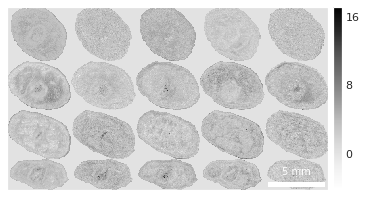

In [8]:
import seaborn_image as seaim
import seaborn as sns

sns.set_theme(style="darkgrid")
# sns.set(rc={'figure.figsize':(19,6)})
height = np.sum(y_dims)
max_im_width = np.max(x_dims)
width = max_im_width * latent_size

im_final = np.zeros((height, width))


y_pos = 0
for i, ims_temp in enumerate(ims):
    d,h,w = ims_temp.shape
    min = np.min(ims_temp)
    max = np.max(ims_temp)
    x_pos = 0
    for k in range(latent_size):
        rescaled = np.copy(ims_temp[k])
        w_delta_2 = (max_im_width-w)/2
        im_final[y_pos:y_pos + h , x_pos+int(w_delta_2):x_pos+int(w_delta_2)+w] = rescaled
        x_pos = x_pos + max_im_width
    y_pos = y_pos + h

im_final[im_final!=0] = im_final[im_final!=0]+3.5
seaim.imgplot(im_final, cmap="Greys", dx=25, units="um", describe=True)
plt.savefig("VI.png", dpi=350)

In [9]:
um = umap.UMAP(n_components=3)
udt = um.fit_transform(dt)
shape = I.GetArray(1000,3).shape
carr = np.zeros((3, shape[1], shape[2]))
for id in range(I.GetNumberOfSpectra()):
    x,y,z = I.GetSpectrumPosition(id)
    carr[:, y, x] = udt[id]



NameError: name 'dt' is not defined

In [ ]:

for i in range(3):
    carr[i,...] = carr[i,...] - np.mean(carr[i,...])
    carr[i,...] = carr[i,...] / np.std(carr[i,...])
    # carr[i,...] = carr[i,...] - np.min(carr[i,...])
    # carr[i,...] = carr[i,...] / np.max(carr[i,...])
print(carr.T.shape)
plt.imshow(carr.T)

In [ ]:
#===================================
# 2.1 Predict embeddings of the images
# using the pre-finetuned model
#===================================

m.eval()
dt = None
for spectra in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    projection = m(torch.tensor(spectra[None,...]).cuda())
    projection_np = projection[1].cpu().detach().numpy()
    if dt is None:
        dt = projection_np
    else:
        dt = np.concatenate([dt, projection_np])


In [ ]:
#===================================
# 2.3 Use UMAP embeddings
#===================================
t = umap.UMAP(random_state=42)
r_0 = t.fit_transform(dt)
c_0 = km_0.fit_predict(r_0)
sea.set_style('darkgrid')
fig = sea.scatterplot(x=r_0[:,0], y=r_0[:,1],hue=c_0, legend=False, palette="colorblind")
plt.title("A", {'fontweight' : 'bold',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'left'})


In [ ]:
# Dataset returns two augmentations of the same ion image Dataset entry
class AugmentedDataset(Dataset):
  def __init__(self, dataset: m2.Dataset, transform_f):
    super().__init__()
    self.dataset = dataset
    self.transform_f = transform_f

  def __len__(self):
    return self.dataset.__len__()

  def __getitem__(self, index):
    I = self.dataset[index]
    X = self.transform_f(I)
    Y = self.transform_f(I)
    return X, Y


def gaussian_suppression(xs, sigma=(100,400)):
  center = np.random.uniform(xs[0], xs[-1])
  # Initializing sigma and muu
  
  sigma = np.random.uniform(sigma[0],sigma[1])
  muu = center
  # Calculating Gaussian array
  supp = np.exp(-( (xs-muu)**2 / ( 2.0 * sigma**2 ) ) )
  return supp


def random_crop(x, min_size=0.3, max_size=1):
  s = x.shape[-1]
  r = ((min_size - max_size) * torch.rand((1,)).item() + max_size)
  i = torch.randint(0,s,(1,)).item()
  ws = int(s*r/2)
  left = i - ws if i - ws > 0 else 0
  right = i + ws + 1 if i + ws + 1  < s else s-1
  x[...,:left] = 0
  x[...,right:] = 0
  return x


blur_kernel_size = 9
